# Multi-Fidelity Bayesian Neural Network (MF-Baynet) Setup

This Jupyter Notebook walks through the key steps for setting up and training Bayesian Neural Networks (BNNs) using the **Multi-Fidelity BNN Library**. The goal of this project is to build models that can leverage datasets with different fidelity levels to make robust predictions with uncertainty quantification. This approach is particularly useful in scenarios where high-fidelity data (e.g., from expensive simulations or experiments) is limited, and low- or mid-fidelity data is more abundant.

We will:
1. Load and import the necessary libraries and configurations.
2. Set up directories to save trained models.
3. Load datasets, normalize them, and prepare them for model training.
4. Train single-fidelity models (low, mid, and high fidelity).
5. Apply transfer learning between models of different fidelity levels.
6. Train a Co-Kriging model to fuse data from multiple fidelity sources.
7. Test the models and visualize the results.

In [1]:
from bnn import BNNDataset
from training import import_settings, setup_model_directory, load_and_normalize_datasets, train_single_fidelity_model, transfer_learning, train_co_kriging_model, test_models, plot_results

### Part 1: Configure the workspace
Now, we will configure the environment by importing the settings defined in yaml file

In [2]:
model_settings, training_settings, dataset_settings = import_settings()
MODEL_PATH = training_settings["MODEL_PATH"]
FIDELITY_COLUMN_NAME = dataset_settings["FIDELITY_COLUMN_NAME"]
INPUT_LABELS = dataset_settings["INPUT_LABELS"]
OUTPUT_LABELS = dataset_settings["OUTPUT_LABELS"]

We create the necessary folder and subfolders for saving the models. If the path already exists, a warning message will be shown

In [3]:
path_exists = setup_model_directory(MODEL_PATH)

Loading and normalizing datasets using the `load_and_normalize_datasets` function.
The function returns:
- `normalized_datasets`: A version of the datasets where all the features (inputs) have been normalized between 1 and 2 (0 and 1 are avoided because some truth values can be 0 and it could create problem when calculates the error). This helps improve model training stability and performance.
- `scaler`: The scaler object used to normalize the data. This is important because the same scaler must be used to normalize future data, including test datasets, to ensure consistency.

In [4]:
normalized_datasets, scaler = load_and_normalize_datasets(dataset_settings, path_exists, MODEL_PATH)

### Part 2: Dataset generation

Now we need to create instances of the `BNNDataset` class for each fidelity level (low-fidelity, mid-fidelity, and high-fidelity). These dataset are going to be used for the training phase.

- `dataset_lf`: Contains the normalized low-fidelity dataset.
- `dataset_mf`: Contains the normalized mid-fidelity dataset.
- `dataset_hf`: Contains the normalized high-fidelity dataset.

Each dataset is assigned to a device (e.g., CPU or GPU) based on the configuration in `model_settings["DEVICE"]`. This setup ensures that the datasets are prepared for training the respective models.


In [5]:
dataset_lf = BNNDataset(normalized_datasets[0], INPUT_LABELS, OUTPUT_LABELS, device=model_settings["DEVICE"])
dataset_mf = BNNDataset(normalized_datasets[1], INPUT_LABELS, OUTPUT_LABELS, device=model_settings["DEVICE"])
dataset_hf = BNNDataset(normalized_datasets[2], INPUT_LABELS, OUTPUT_LABELS, device=model_settings["DEVICE"])

This block of code splits the datasets into training, validation, and test sets for each fidelity level.

- `train_lf` and `valid_lf`: The low-fidelity dataset is split into training and validation sets using a specified training size (`LF_TRAIN_SIZE`) and a random seed for reproducibility.
- `train_mf` and `valid_mf`: The mid-fidelity dataset is similarly split into training and validation sets based on the corresponding training size (`MF_TRAIN_SIZE`).
- `train_hf`, `valid_hf`, and `test_hf`: The high-fidelity dataset is split into training, validation, and test sets using the specified sizes (`HF_TRAIN_SIZE` and `HF_VALID_SIZE`), ensuring that the remaining data is reserved for testing and evaluating the models, as they are used as truth values.

The sizes of each dataset are printed for verification, showing the total dataset size for each fidelity level and the sizes of the respective training, validation, and test sets.

In [6]:
train_lf, valid_lf = dataset_lf.train_val_split(train_size=dataset_settings["LF_TRAIN_SIZE"], seed=model_settings["SEED"])
train_mf, valid_mf = dataset_mf.train_val_split(train_size=dataset_settings["MF_TRAIN_SIZE"], seed=model_settings["SEED"])
train_hf, valid_hf, test_hf = dataset_hf.train_val_test_split(train_size = dataset_settings["HF_TRAIN_SIZE"],
                                                                  val_size = dataset_settings["HF_VALID_SIZE"],
                                                                  seed = model_settings["SEED"])

print("Size LF Dataset:", len(dataset_lf), "|", 
      "Size MF Dataset:", len(dataset_mf), "|", 
      "Size HF Dataset:", len(dataset_hf))

print("Train LF size:", len(train_lf), ",", 
      "Valid LF size:", len(valid_lf), "|", 
      "Train MF size:", len(train_mf), ",", 
      "Valid MF size:", len(valid_mf), "|",  
      "Train HF size:", len(train_hf), ",", 
      "Valid HF size:", len(valid_hf), ",", 
      "Test set size:", len(test_hf))

Size LF Dataset: 625 | Size MF Dataset: 48 | Size HF Dataset: 56
Train LF size: 437 , Valid LF size: 188 | Train MF size: 33 , Valid MF size: 15 | Train HF size: 11 , Valid HF size: 11 , Test set size: 34


### Part 3: Training

Now that the datasets have been split into training, validation, and test sets for each fidelity level, we can proceed with training the models. In this step, we'll train separate Bayesian Neural Networks (BNNs) for the low-fidelity, mid-fidelity, and high-fidelity datasets. Each model will be trained using the corresponding training set and validated using the validation set. Additionally, transfer learning can be applied to fine-tune models from one fidelity level to another, and Co-Kriging can be used for multi-fidelity data fusion.

The training process involves:
1. **Low-Fidelity Model**: Train the model on the low-fidelity dataset (`train_lf`).
2. **Mid-Fidelity Model**: Train the model on the mid-fidelity dataset (`train_mf`).
3. **High-Fidelity Model**: Train the model on the high-fidelity dataset (`train_hf`).
4. **Transfer Learning**: Fine-tune a low- or mid-fidelity model using high-fidelity data.
5. **Co-Kriging Model**: Use Co-Kriging to combine predictions from multiple fidelity levels.


In [7]:
models_to_test = []

Creating dataloader (train size: 437, valid size: 188)...
Initializing model architecture...
BNN(
  (activation): LeakyReLU(negative_slope=0.01)
  (in_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=2, out_features=176, bias=True)
  (hidden_layers): ModuleList(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
    (1): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=144, bias=True)
    (2): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=144, out_features=176, bias=True)
    (3): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
  )
  (out_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=2, bias=True)
)
[BNN_LF] >> Model initialized (228388 learnable / 228388 total parameters)

Start Training

|████████████████████|(3581/5000) (0.37s avg time) ETA: ~09 min -  MSE (TRAIN) : 0.020416, MSE (VAL) : 0.009069 -- BEST Val L

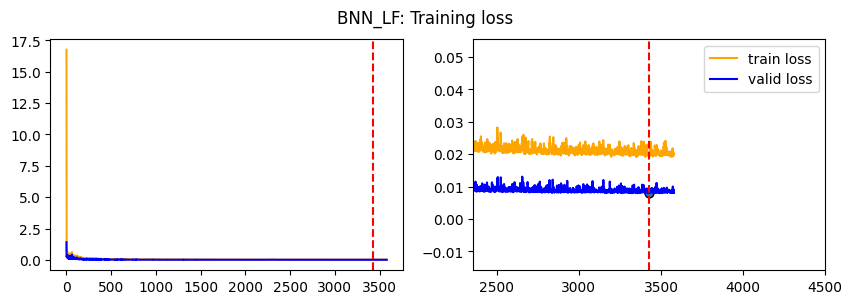

Saving best model at epoch 3429
Total enlapsed time: 1377.79 sec
[BNN_LF] >> Model Saved


In [8]:
if training_settings["TRAIN_LF"]: 
    bnn_lf_model = train_single_fidelity_model("LF", 
                                               INPUT_LABELS, 
                                               OUTPUT_LABELS, 
                                               model_settings, 
                                               training_settings, 
                                               MODEL_PATH, 
                                               train_lf, 
                                               valid_lf)
    models_to_test.append(bnn_lf_model)

Creating dataloader (train size: 33, valid size: 15)...
Initializing model architecture...
BNN(
  (activation): LeakyReLU(negative_slope=0.01)
  (in_layer): BayesLinear(prior_mu=0, prior_sigma=0.0526, in_features=2, out_features=160, bias=True)
  (hidden_layers): ModuleList(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.0526, in_features=160, out_features=80, bias=True)
  )
  (out_layer): BayesLinear(prior_mu=0, prior_sigma=0.0526, in_features=80, out_features=2, bias=True)
)
[BNN_MF] >> Model initialized (27044 learnable / 27044 total parameters)

Start Training

|████████████████████|(6149/10000) (0.02s avg time) ETA: ~02 min -  MSE (TRAIN) : 0.010341, MSE (VAL) : 0.009611 -- BEST Val Loss : 0.005645 (at epoch 5647) Eary Stopping in: 0001   
Early stopping at epoch 5647
Total enlapsed time: 147.26 sec


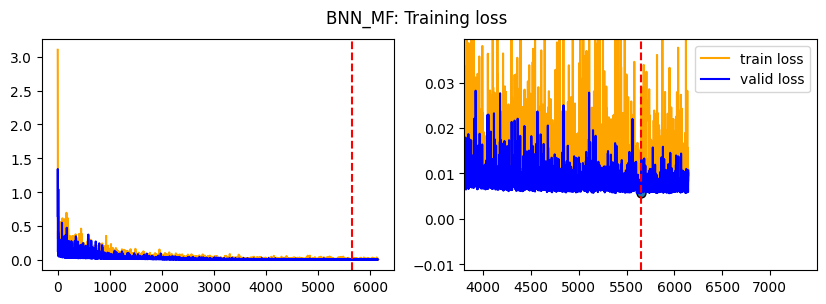

Saving best model at epoch 5647
Total enlapsed time: 147.84 sec
[BNN_MF] >> Model Saved


In [9]:
if training_settings["TRAIN_MF"]:
    bnn_mf_model = train_single_fidelity_model("MF", 
                                            INPUT_LABELS, 
                                            OUTPUT_LABELS, 
                                            model_settings, 
                                            training_settings, 
                                            MODEL_PATH, 
                                            train_mf, 
                                            valid_mf)
    models_to_test.append(bnn_mf_model)

Creating dataloader (train size: 11, valid size: 11)...
Initializing model architecture...
BNN(
  (activation): LeakyReLU(negative_slope=0.01)
  (in_layer): BayesLinear(prior_mu=0, prior_sigma=0.0596, in_features=2, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.0596, in_features=128, out_features=160, bias=True)
    (1): BayesLinear(prior_mu=0, prior_sigma=0.0596, in_features=160, out_features=176, bias=True)
  )
  (out_layer): BayesLinear(prior_mu=0, prior_sigma=0.0596, in_features=176, out_features=2, bias=True)
)
[BNN_HF] >> Model initialized (99428 learnable / 99428 total parameters)

Start Training

|████████████████████|(12719/100000) (0.02s avg time) ETA: ~28 min -  MSE (TRAIN) : 0.004171, MSE (VAL) : 0.008642 -- BEST Val Loss : 0.004622 (at epoch 11717) Eary Stopping in: 0001     
Early stopping at epoch 11717
Total enlapsed time: 243.63 sec


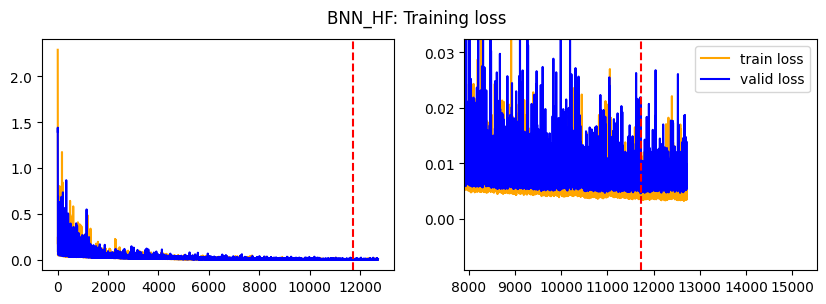

Saving best model at epoch 11717
Total enlapsed time: 244.34 sec
[BNN_HF] >> Model Saved


In [10]:
if training_settings["TRAIN_HF"]:
    bnn_hf_model = train_single_fidelity_model("HF", 
                                            INPUT_LABELS, 
                                            OUTPUT_LABELS, 
                                            model_settings, 
                                            training_settings, 
                                            MODEL_PATH, 
                                            train_hf, 
                                            valid_hf)
    models_to_test.append(bnn_hf_model)

Creating dataloader (train size: 33, valid size: 15)...
Initializing model architecture...
BNN(
  (activation): LeakyReLU(negative_slope=0.01)
  (in_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=2, out_features=176, bias=True)
  (hidden_layers): ModuleList(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
    (1): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=144, bias=True)
    (2): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=144, out_features=176, bias=True)
    (3): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
  )
  (out_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=2, bias=True)
  (mse_loss): MSELoss()
  (kl_loss): BKLLoss()
)
[BNN_TL_MF] >> Model initialized (114052 learnable / 228388 total parameters)

Start Training

|████████████████████|(2181/8000) (0.04s avg time) ETA: ~04 min -  MSE (TRAIN

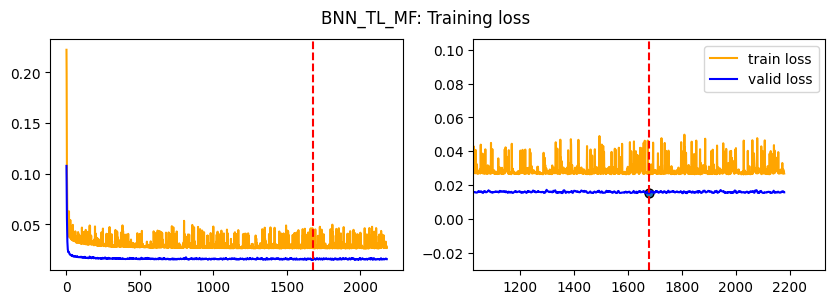

Saving best model at epoch 1679
Total enlapsed time: 81.33 sec
[BNN_TL_MF] >> Model Saved


In [11]:
if training_settings["TRAIN_TL_MF"]:
    bnn_tl_mf_model = transfer_learning("TL_MF",
                                        model_settings, 
                                        training_settings, 
                                        MODEL_PATH, 
                                        train_mf, 
                                        valid_mf, 
                                        bnn_lf_model)
    models_to_test.append(bnn_tl_mf_model)

Creating dataloader (train size: 11, valid size: 11)...
Initializing model architecture...
BNN(
  (activation): LeakyReLU(negative_slope=0.01)
  (in_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=2, out_features=176, bias=True)
  (hidden_layers): ModuleList(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
    (1): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=144, bias=True)
    (2): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=144, out_features=176, bias=True)
    (3): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=176, bias=True)
  )
  (out_layer): BayesLinear(prior_mu=0, prior_sigma=0.0126, in_features=176, out_features=2, bias=True)
  (mse_loss): MSELoss()
  (kl_loss): BKLLoss()
)
[BNN_TL_HF] >> Model initialized (708 learnable / 228388 total parameters)

Start Training

|████████████████████|(1445/8000) (0.15s avg time) ETA: ~17 min -  MSE (TRAIN) :

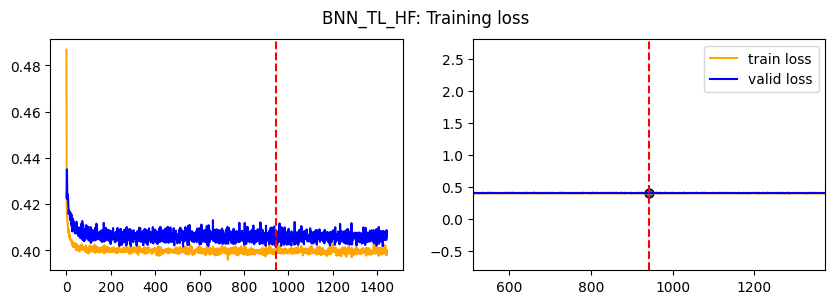

Saving best model at epoch 943
Total enlapsed time: 210.86 sec
[BNN_TL_HF] >> Model Saved


In [12]:
if training_settings["TRAIN_TL_HF"]:
    bnn_tl_hf_model = transfer_learning("TL_HF",
                                        model_settings, 
                                        training_settings, 
                                        MODEL_PATH, 
                                        train_hf, 
                                        valid_hf, 
                                        bnn_tl_mf_model)
    models_to_test.append(bnn_tl_hf_model)

In [13]:
if training_settings["TRAIN_CK"]: 
    ck_df_model = train_co_kriging_model(training_settings, 
                                         MODEL_PATH, 
                                         model_settings, 
                                         train_hf+valid_hf, 
                                         bnn_lf_model)
    models_to_test.append(ck_df_model)

Training Co-Kriging...
[COKriging] >> Model Saved


### Part 4: Testing and visualizing the results

Once the models have been trained, we evaluate their performance on the high-fidelity test set (`test_hf`). The function `test_models` performs the following steps:
- It loads the trained models and applies them to the test set.
- The predictions are compared against the actual outputs to compute error metrics.
- The results are saved to a DataFrame (`error_df`) for easy visualization.

In [14]:
error_df = test_models(models_to_test, test_hf, scaler, OUTPUT_LABELS, MODEL_PATH)
display(error_df)

Testing models...


,Model Name,cl ERR%,cl STD%,cm ERR%,cm STD%,ERR_TOT%,STD_TOT%
0,BNN_LF,16.14,0.42,42.76,0.36,32.317319,0.405613
1,BNN_MF,8.57,3.66,8.56,1.99,8.566921,2.961773
2,BNN_HF,6.46,4.10,3.15,2.21,5.083245,3.328038
3,BNN_TL_MF,10.90,0.44,10.16,0.23,10.539879,0.352347
4,BNN_TL_HF,4.84,0.46,3.94,0.42,4.412142,0.443533
5,COKriging,5.25,3.03,6.23,9.63,5.761762,7.205143


### Result Explanation:
- **Model Name**: The name of the model being tested (e.g., BNN_LF is the low-fidelity BNN model).
- **cl ERR%**: The percentage error for predicting lift coefficient "cl".
- **cl STD%**: The percentage standard deviation of the error for the "cl" output.
- **cm ERR%**: The percentage error for predicting moment coefficient "cm".
- **cm STD%**: The percentage standard deviation of the error for the "cm" output.
- **ERR_TOT%**: The total percentage error for the model across all outputs.
- **STD_TOT%**: The total percentage standard deviation of the error.

### Observations:
- **BNN_LF** has a relatively high total error (32.32%), which is expected since it is trained on low-fidelity data.
- **BNN_MF** performs significantly better with a total error of 8.57%, showing the benefit of mid-fidelity data.
- **BNN_HF** shows the best performance with a total error of 5.08%, as expected from high-fidelity training.
- **BNN_TL_HF** (transfer learning from mid-fidelity to high-fidelity) also performs well with a total error of 4.41%, demonstrating the effectiveness of transfer learning.
- **COKriging** provides a balanced approach, fusing multiple fidelities for a total error of 5.76%, although it has a higher standard deviation in the predictions (7.21%).

This table allows us to compare the models in terms of both accuracy and uncertainty (standard deviation), highlighting the trade-offs between fidelity levels and transfer learning.